In [1]:
library(tibble)
library(RColorBrewer)
library(stringr)
library(plyr)
library(ggplot2)
library(dplyr)
res0 <- read.csv('scib_results_lung5loc_pool_celltype.csv', check.names = FALSE, row.names = 1)

Warning message:
“package ‘tibble’ was built under R version 4.0.5”
Warning message:
“package ‘RColorBrewer’ was built under R version 4.0.5”
Warning message:
“package ‘stringr’ was built under R version 4.0.5”
Warning message:
“package ‘plyr’ was built under R version 4.0.5”
Warning message:
“package ‘dplyr’ was built under R version 4.0.5”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
res0

,Isolated labels,KMeans NMI,KMeans ARI,Silhouette label,cLISI,Silhouette batch,Graph connectivity,Bio conservation,Batch correction,Total
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
X_FinVAE,0.4621543847024441,0.7885140984942469,0.49067768513198906,0.5321719646453857,0.9923942285754813,0.89798676793506,0.9497727813849786,0.6531824723099093,0.9238797746600194,0.7885311234849643
X_scANVI,0.39396848529577255,0.6993327331673653,0.36278216445778466,0.48889502696692944,0.983950348069672,0.8820998840122763,0.757687195341323,0.5857857515915048,0.8198935396767997,0.7028396456341522
X_pca_combat,0.41478922218084335,0.6784727228367243,0.3443376858349637,0.4864674527198076,0.9858053413399948,0.8860267676150867,0.7536975751052504,0.5819744849824667,0.8198621713601686,0.7009183281713176
X_scPoli,0.23154392838478088,0.6904724339937514,0.3471324757862379,0.4705953449010849,0.9811941839777749,0.8026508832334974,0.696001439739905,0.544187673408726,0.7493261614867013,0.6467569174477137
X_scVI,0.45395445823669434,0.6974962207028412,0.358575879483425,0.49306886456906796,0.9848757600845046,0.9026521618602319,0.7545397099838789,0.5975942366153066,0.8285959359220554,0.713095086268681
X_pca,0.4163619503378868,0.6905774632160591,0.3325113523513443,0.49213928543031216,0.9866430343833287,0.9051847112464062,0.7498289421898952,0.5836466171437862,0.8275068267181507,0.7055767219309684
Metric type,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Batch correction,Batch correction,Aggregate score,Aggregate score,Aggregate score


In [3]:
for (i in 1:(nrow(res0)-1)){
  res0[i, colnames(res0) == 'Batch correction'] <- mean(as.numeric(res0[i, (res0['Metric type',] == 'Batch correction') & (! colnames(res0) %in% c("KBET", "iLISI", "PCR comparison"))]))
  res0[i, colnames(res0) == 'Total'] <- as.numeric(res0[i, 'Batch correction']) * 0.4 + as.numeric(res0[i, 'Bio conservation']) * 0.6
}

In [4]:
res0 <- res0[1:(nrow(res0)-1),]
res0 <- mutate_all(res0, function(x) as.numeric(as.character(x)))
res0 <- tibble::rownames_to_column(res0, "Method")

res0$Method <- plyr::mapvalues(res0$Method, 
                                from = c("X_FinVAE", "X_scANVI", "X_scVI", "X_pca", "X_scPoli", "X_pca_combat"), 
                                to = c("inVAE", "scANVI", "scVI", "PCA", "scPoli", "Combat (PCA)"))

In [5]:
res0

Method,Isolated labels,KMeans NMI,KMeans ARI,Silhouette label,cLISI,Silhouette batch,Graph connectivity,Bio conservation,Batch correction,Total
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
inVAE,0.4621544,0.7885141,0.4906777,0.5321720,0.9923942,0.8979868,0.9497728,0.6531825,0.9238798,0.7614614
scANVI,0.3939685,0.6993327,0.3627822,0.4888950,0.9839503,0.8820999,0.7576872,0.5857858,0.8198935,0.6794289
Combat (PCA),0.4147892,0.6784727,0.3443377,0.4864675,0.9858053,0.8860268,0.7536976,0.5819745,0.8198622,0.6771296
scPoli,0.2315439,0.6904724,0.3471325,0.4705953,0.9811942,0.8026509,0.6960014,0.5441877,0.7493262,0.6262431
scVI,0.4539545,0.6974962,0.3585759,0.4930689,0.9848758,0.9026522,0.7545397,0.5975942,0.8285959,0.6899949
PCA,0.4163620,0.6905775,0.3325114,0.4921393,0.9866430,0.9051847,0.7498289,0.5836466,0.8275068,0.6811907


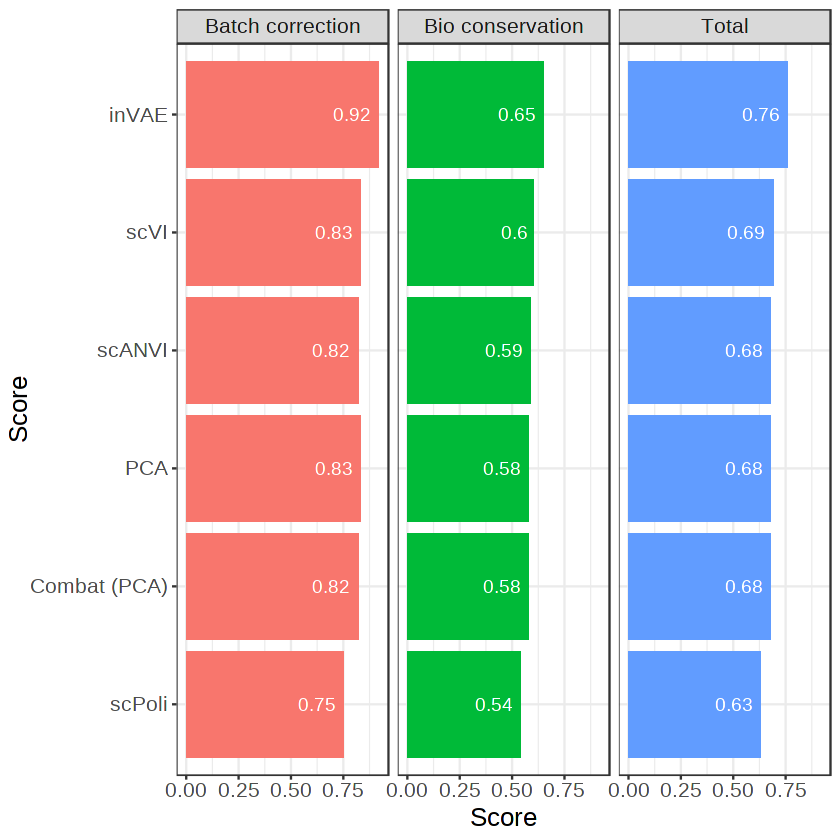

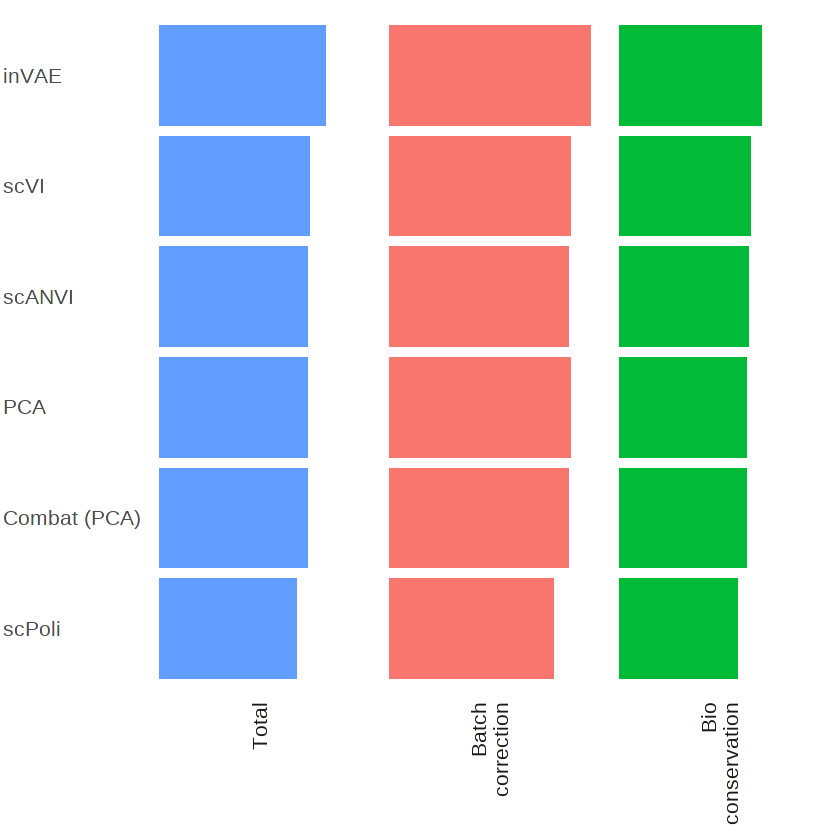

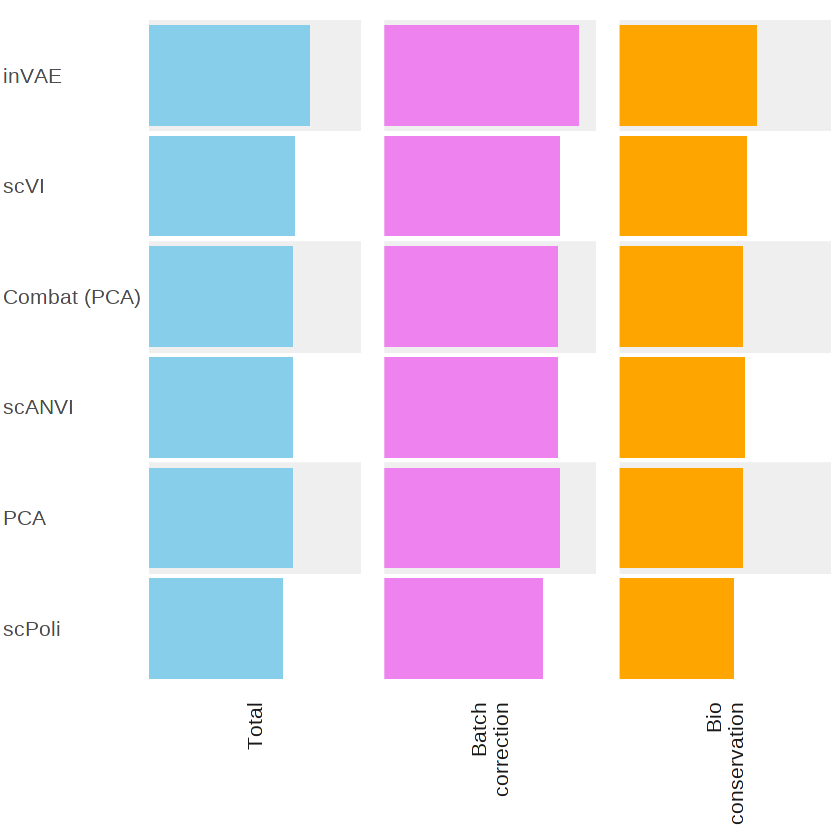

In [6]:
res0 <- res0[,c("Method", "Batch correction", "Bio conservation", "Total")]
res0 <- res0[order(res0$Total,decreasing=TRUE),]

metrics <- tidyr::pivot_longer(res0, cols =-c("Method"), names_to = "Testing", values_to = "Score")
metrics$Score <- round(metrics$Score, digits=2)

metrics2 <- metrics
metrics2$Testing <- str_replace_all(metrics2$Testing, " ", "\n")

library(ggplot2)

n_methods <- length(unique(metrics$Method))

  
ggplot(metrics, aes(x=reorder(Method, Score), y=Score, label=Score, fill = Testing)) + geom_bar(stat='identity') + 
  geom_text(color='white', hjust = 1.2, position = position_dodge(width = .75)) +
  facet_wrap(~Testing) + coord_flip() + xlab('Score') + theme_bw() + 
  theme(legend.position = "none", text=element_text(size=15))

ggplot(metrics2, aes(x=reorder(Method, Score), y=Score, label=Score, fill = Testing)) + geom_bar(stat='identity') + 
  facet_wrap(~~factor(Testing, c("Total", "Batch\ncorrection", "Bio\nconservation")), strip.position = "bottom", ) + coord_flip() + theme_minimal() +
  theme(legend.position = "none", text=element_text(size=15), 
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        axis.text.x=element_blank(), axis.title.x=element_blank(), axis.title.y=element_blank(),
        axis.text.y = element_text(hjust = 0), strip.text.x.bottom = element_text(angle = 90, hjust=1))

library(dplyr)
library(ggplot2)

# First, modify your data frame to include an alternating color column
# and create a total_score column for ordering
metrics2 <- metrics %>%
  group_by(Method) %>%
  mutate(total_score = Score[Testing == "Total"]) %>%
  ungroup() %>%
  arrange(total_score) %>%
  mutate(Method = factor(Method, levels = unique(Method)),
         row_color = if_else(as.numeric(Method) %% 2 == 0, "even", "odd"))

metrics2$Testing <- str_replace_all(metrics2$Testing, " ", "\n")


# Then, use this modified data frame in your ggplot code
ggplot(metrics2, aes(x = Method, y = Score, fill = Testing)) + 
  geom_tile(aes(y = 0.5, height = Inf, fill = row_color), alpha = 0.2) +
  geom_col(position = position_dodge(width = 0.9)) +
  facet_wrap(~factor(Testing, levels = c("Total", "Batch\ncorrection", "Bio\nconservation")), 
             strip.position = "bottom", scales = "free_x") + 
  coord_flip() + 
  theme_minimal() +
  scale_fill_manual(values = c("even" = "gray70", "odd" = "white", 
                               "Total" = "skyblue", "Batch\ncorrection" = "violet", "Bio\nconservation" = "orange"), 
                    guide = "none") +
  scale_y_continuous(limits = c(0,1), expand = c(0, 0)) +
  theme(
    legend.position = "none", 
    text = element_text(size = 15), 
    panel.grid.major = element_blank(), 
    panel.grid.minor = element_blank(),
    axis.text.x = element_blank(), 
    axis.title.x = element_blank(), 
    axis.title.y = element_blank(),
    axis.text.y = element_text(hjust = 0), 
    strip.text.x.bottom = element_text(angle = 90, hjust = 1),
    panel.spacing = unit(1, "lines")
  )

ggsave("invae_lung5loc_plot_updated.pdf", width = 5, height = 10)